In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

set2_colors = plt.get_cmap("Set2").colors
plt.rcParams['pdf.fonttype'] = 42

In [2]:
# root directory where processed mutation data are stored
# if using the zenodo data, this should point to the location of the base zenodo directory (including wes, wgs, etc subfolders)
data_dir = ""

save_plots = True
# directory where you want to save pdf versions of the plots (only use if save_plots = TRUE)
plots_dir = ""

In [3]:
expected_clonal = pd.read_csv(data_dir+"wgs_wes/clonal_noshared_WES_WGS_polycalls.csv", index_col=0)
combined_maf = pd.read_csv(data_dir+"wgs/combined_noshared_FILTERED_muts_WGS.maf", sep="\t")
expected_clonal = expected_clonal[expected_clonal["has_WGS"]]

/tmp/ipykernel_568/3746815974.py:2: DtypeWarning: Columns (85,87,88,90,122) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_maf = pd.read_csv(data_dir+"wgs/combined_noshared_FILTERED_muts_WGS.maf", sep="\t")


In [9]:
def compute_binomial_bayes_CI(successes, failures, width=0.95):
    upper_quantile = 1 - (1-width)/2
    lower_quantile = (1-width)/2
    lower, upper = stats.beta.ppf([lower_quantile, upper_quantile], 1+successes, 1+failures)
    return lower, upper

def compute_errorbars(binom_data):
    return compute_binomial_bayes_CI(np.sum(binom_data.astype("boolean")), np.sum(~binom_data.astype("boolean")))

def plot_dist(maf, active_ax, plot_var="vaf", group_var=None, purity=None, common_norm=True, plot_color="darkgrey"):
    if group_var is None:
        sns.kdeplot(x=maf[plot_var], common_norm=common_norm, ax=active_ax, legend=None, color=plot_color)
    else:
        sns.kdeplot(x=maf[plot_var], hue=maf[group_var], common_norm=common_norm, ax=active_ax, legend=None, color=plot_color)
        
    if purity is not None:
        active_ax.axvline(x=purity/2, color="k", linestyle="dashed")
    active_ax.set_xlim(0,1)
    return

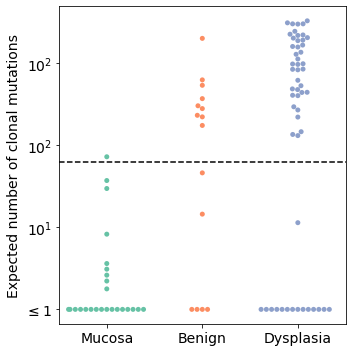

In [23]:
# FIGURE 2c
cutoff = 27 + 36

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.swarmplot(x=expected_clonal["stage"], y=np.log10(np.maximum(expected_clonal["new_clonal_0.95_WGS"],1)), hue=expected_clonal["stage"], order=["Mucosa", "Benign", "Dysplasia"], hue_order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", ax=axs, legend=None)
#axs.set_yscale("log")
plt.xlabel("", fontsize=14)
plt.ylabel("Expected number of clonal mutations", fontsize=14) 
axs.axhline(y=np.log10(cutoff), color="k", linestyle="dashed")
plt.yticks(ticks = [0, 1, 2, 3], labels = ["$\leq 1$", "$10^{1}$", "$10^{2}$", "$10^{2}$"], fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig2c_clonal_bystage_strip.pdf")
plt.show()

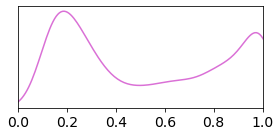

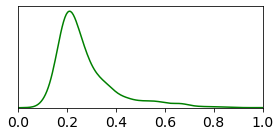

In [17]:
# FIGURE 2d
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,2))
to_plot = combined_maf[combined_maf["Tumor_Sample_Barcode"]=="F074B"]
plot_dist(to_plot, axs, plot_var="purity_ccf", common_norm=True, plot_color="orchid")
plt.ylabel("", fontsize=14)
plt.xlabel("", fontsize=14)
plt.yticks(ticks=[], fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig2d_F074B_mono_dists.pdf")

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,2))
to_plot = combined_maf[combined_maf["Tumor_Sample_Barcode"]=="F038"]
plot_dist(to_plot, axs, plot_var="purity_ccf", common_norm=True, plot_color="green")
plt.ylabel("", fontsize=14)
plt.xlabel("", fontsize=14)
plt.yticks(ticks=[], fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig2d_F038_poly_dists.pdf")
plt.show()

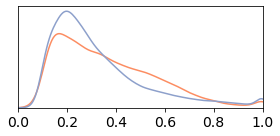

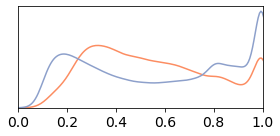

In [7]:
# FIGURE 2e

new_labels = ["Normal\nmucosa", "Benign\npolyclonal", "Benign\nmonoclonal", "Dysplasia\npolyclonal", "Dysplasia\nmonoclonal"]
relabel_ticks = dict(zip(["normal", "Benign_True", "Benign_False", "Dysplasia_True", "Dysplasia_False"], new_labels))

sample_to_poly = dict(zip(expected_clonal.index, expected_clonal["is_poly"]))
combined_maf["is_poly"] = [sample_to_poly[x] for x in combined_maf["Tumor_Sample_Barcode"]]

combined_maf["plot_cat"] = ["normal" if combined_maf.iloc[i]["Stage"] == "Mucosa" else combined_maf.iloc[i]["Stage"]+"_"+str(combined_maf.iloc[i]["is_poly"]) for i in range(len(combined_maf))]
combined_maf["plot_cat"] = [relabel_ticks[x] if x in relabel_ticks else x for x in combined_maf["plot_cat"]]

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,2))
to_plot = combined_maf[combined_maf["plot_cat"]=="Normal"]
to_plot = combined_maf[combined_maf["plot_cat"]=="Benign\npolyclonal"]
plot_dist(to_plot, axs, plot_var="purity_ccf", common_norm=True, plot_color=set2_colors[1])
to_plot = combined_maf[combined_maf["plot_cat"]=="Dysplasia\npolyclonal"]
plot_dist(to_plot, axs, plot_var="purity_ccf", common_norm=True, plot_color=set2_colors[2])
plt.ylabel("", fontsize=14)
plt.xlabel("", fontsize=14)
plt.yticks(ticks=[], fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig2e_poly_combined_dists.pdf")

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(4,2))
to_plot = combined_maf[combined_maf["plot_cat"]=="Normal"]
to_plot = combined_maf[combined_maf["plot_cat"]=="Benign\nmonoclonal"]
plot_dist(to_plot, axs, plot_var="purity_ccf", common_norm=True, plot_color=set2_colors[1])
to_plot = combined_maf[combined_maf["plot_cat"]=="Dysplasia\nmonoclonal"]
plot_dist(to_plot, axs, plot_var="purity_ccf", common_norm=True, plot_color=set2_colors[2])
plt.ylabel("", fontsize=14)
plt.xlabel("", fontsize=14)
plt.yticks(ticks=[], fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig2e_mono_combined_dists.pdf")
plt.show()

/tmp/ipykernel_568/1863071365.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=expected_clonal["stage"], y=expected_clonal["is_poly"], order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", errorbar=compute_errorbars)


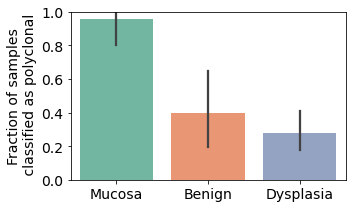

In [12]:
# FIGURE 2f

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
sns.barplot(x=expected_clonal["stage"], y=expected_clonal["is_poly"], order=["Mucosa", "Benign", "Dysplasia"], palette="Set2", errorbar=compute_errorbars)
plt.ylabel("Fraction of samples\n classified as polyclonal", fontsize=14)
plt.xlabel("", fontsize=14)
plt.ylim(0,1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()
if save_plots:
    plt.savefig(plots_dir+"Fig2f_clonal_bystage_bar.pdf")
plt.show()